In [29]:
# Variational Graph Auto-Encoder implementation for fMRI time series discimination (real vs. synthetic)

# Anish Kochhar, Imperial College London, May 2025

In [1]:
from wbm.data_loader import BOLDDataLoader
from wbm.utils import load_discriminator, load_encoder, DEVICE
from discriminator.graph_builder import GraphBuilder

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import os, random, time
from typing import List
from pathlib import Path
from copy import deepcopy
from torch_geometric.utils import to_dense_adj, dropout_edge
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINConv, VGAE, global_add_pool
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
## Graph Augmentations called in train_contrastive

def alignment(z1: torch.Tensor, z2: torch.Tensor, alpha: float = 2):
    """
    Alignment loss: encourages positive pairs (z1, z2) to be close. Assumes z1 and z2 are L2-normalized
    """
    return (F.normalize(z1, dim=1) * F.normalize(z2, dim=1)).sum(dim=1).mean().item()
    # return (z1 - z2).norm(p=2, dim=1).pow(alpha).mean()


def uniformity(z: torch.Tensor, t: float = 2):
    """
    Uniformity loss: encourages representations to be spread out (Wang & Isola, 2020)
    Lower values mean more 'collapse' to the same point
    """
    z = F.normalize(z, dim=1)
    return (torch.pdist(z, p=2).pow(2).mul(-t).exp().mean()).log().item()


def graph_augment(data, drop_p = 0.2, mask_p = 0.2):
    """ Applies random edge dropout and node feature masking """
    edge_index, edge_weight = dropout_edge(data.edge_index, p=drop_p, training=True, force_undirected=True)
    x = data.x.clone()
    mask = torch.rand_like(x) < mask_p
    x[mask] = 0.0
    new_data = data.clone()
    new_data.edge_index, new_data.edge_weight, new_data.x = edge_index, edge_weight, x
    return new_data


    # data_aug = data.clone()
    # edge_index, edge_weight = dropout_edge(data.edge_index, p=drop_p, training=True, force_undirected=True)
    # data_aug.edge_index = edge_index
    # data_aug.edge_weight = edge_weight

    # x = data.x.clone()
    # mask = torch.rand_like(x) < mask_p
    # x[mask] = 0.0
    # data_aug.x = x
    
    # if isinstance(data, Batch):
    #     data_aug.batch = data.batch
    #     if hasattr(data, 'ptr'):
    #         data_aug.ptr = data.ptr
    # return data_aug

In [3]:
import scipy.stats
from sklearn.manifold import TSNE

# MARK: Helper functions for visualisation

def visualize_reconstruction(z, data, encoder, device="cuda"):
    encoder.eval()
    data = data.to(device)

    with torch.no_grad():
        preds = encoder.decoder(z, data.edge_index, sigmoid=False)

        edge_mean = data.edge_weight.mean()
        edge_std = data.edge_weight.std() + 1e-6
        preds_rescaled = preds * edge_std + edge_mean # Rescale to ground truth scale

        A_true = to_dense_adj(data.edge_index, edge_attr=data.edge_weight)[0].cpu().numpy()
        A_pred = to_dense_adj(data.edge_index, edge_attr=preds_rescaled)[0].cpu().numpy()

        # Flatten upper triangle for correlation stats
        triu_indices = np.triu_indices_from(A_true, k=1)
        true_vals = A_true[triu_indices]
        pred_vals = A_pred[triu_indices]

        mse = np.mean((pred_vals - true_vals) ** 2)
        pearson = scipy.stats.pearsonr(pred_vals, true_vals)[0]
        spearman = scipy.stats.spearmanr(pred_vals, true_vals)[0]

        print(f"[Epoch Stats] Pred mean: {pred_vals.mean():.4f} | min: {pred_vals.min():.4f} | max: {pred_vals.max():.4f}")
        print(f"[Epoch Stats] True mean: {true_vals.mean():.4f} | min: {true_vals.min():.4f} | max: {true_vals.max():.4f}")
        print(f"[Epoch Stats] Pearson Corr: {pearson:.4f} | Spearman Corr: {spearman:.4f}")
        print(f"[Epoch Stats] MSE (dense): {mse:.6f}")
        print(f"[Epoch Stats] Diagonal Pred Mean: {np.diag(A_pred).mean():.4f}")


        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        im0 = axs[0].imshow(A_true, cmap="viridis", vmin=0, vmax=1)
        axs[0].set_title("True Adjacency (Weighted)")
        plt.colorbar(im0, ax=axs[0])

        im1 = axs[1].imshow(A_pred, cmap="viridis", vmin=0, vmax=1)
        axs[1].set_title("Reconstructed Adjacency")
        plt.colorbar(im1, ax=axs[1])

        plt.tight_layout()
        plt.show()

    encoder.train()

def plot_tsne(discriminator, dataset, device="cuda"):
    discriminator = discriminator.to(device)
    discriminator.eval()

    z_list = []
    labels = []

    for data in dataset:
        data = data.to(device)
        with torch.no_grad():
            z = discriminator.encoder(data)
            z_graph = z.mean(dim=0).cpu().numpy()
            z_list.append(z_graph)
            labels.append(data.y.item())
        
    z_array = np.vstack(z_list)
    labels = np.array(labels)

    tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='random')
    z_2d = tsne.fit_transform(z_array)

    plt.figure(figsize=(8, 6))
    plt.scatter(z_2d[labels == 0, 0], z_2d[labels == 0, 1], label="Fake", alpha=0.6, marker='x')
    plt.scatter(z_2d[labels == 1, 0], z_2d[labels == 1, 1], label="Real", alpha=0.6, marker='o')
    plt.legend()
    plt.title("t-SNE of Graph-Level Latent Embeddings")
    plt.xlabel("TSNE-1")
    plt.ylabel("TSNE-2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def tsne_plot(embeddings, labels):
    Z2 = TSNE(perplexity=30).fit_transform(embeddings)
    plt.scatter(Z2[labels==0,0], Z2[labels==0,1], c='r', marker='x', alpha=0.5, label='fake')
    plt.scatter(Z2[labels==1,0],Z2[labels==1,1], c='b', alpha=0.5, label='real')
    plt.legend()
    plt.title("t-SNE graph embeddings")
    plt.show()

In [4]:
# Encoder
class GraphEncoder(nn.Module):      # 4-layer GIN
    def __init__(self, in_dim, hidden=64, latent=32):
        super().__init__()
        self.convs = nn.ModuleList()
        for k in range(4):
            dim_in = in_dim if k == 0 else hidden
            mlp = nn.Sequential(nn.Linear(dim_in, hidden), nn.ReLU(), nn.Linear(hidden, hidden))
            self.convs.append(GINConv(mlp))
        self.readout = nn.Linear(hidden, latent)

    def forward(self, data):
        x = data.x
        for conv in self.convs:
            x = conv(x, data.edge_index)
        z = F.normalize(self.readout(x), p=2, dim=-1)
        return z

class NTXentLoss(nn.Module):
    def __init__(self, temperature = 0.5):
        super().__init__()
        self.t = temperature
    
    def forward(self, z1, z2):
        B = z1.size(0)
        z = torch.cat([z1, z2], dim=0)
        sim = torch.mm(z, z.t()) / self.t # Cosine sims
        labels = torch.arange(B, device=z.device).repeat(2)
        loss = F.cross_entropy(sim, labels)
        return loss

class GraphAttentionPool(nn.Module):
    def __init__(self, latent):
        super().__init__()
        self.att = nn.Sequential(nn.Linear(latent, latent), nn.Tanh(), nn.Linear(latent, 1))

    def forward(self, z: torch.Tensor, batch: torch.Tensor):
        """
        Attention weights normalised within each graph

        z: (N, latent), batch: (N, ) graph-id for every node, returns: (batch, latent)
        """
        # Attention score per node
        alpha = self.att(z).squeeze(-1)  # (N)
        alpha = torch.exp(alpha - alpha.max())

        alpha_sum = global_add_pool(alpha, batch) # (B, )
        alpha = alpha / (alpha_sum[batch] + 1e-8) # (N, )
        # Weighted node aggregation
        graph_z = global_add_pool(z * alpha.unsqueeze(1), batch) # (B, latent)
        return graph_z
    
class GraphClassifier(nn.Module):
    """ Attention-pool + 3-layer MLP, returns probability in [0, 1] """
    def __init__(self, latent = 32):
        super().__init__()
        self.pool = GraphAttentionPool(latent)
        self.mlp = nn.Sequential(
            nn.Linear(latent, 128), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    
    def forward(self, z, batch):
        z_graph = self.pool(z, batch)
        return torch.sigmoid(self.mlp(z_graph)).view(-1) # (B, )

class CriticHead(nn.Module):  
    """ Single layer Wasserstein critic """
    def __init__(self, latent = 32):
        super().__init__()
        self.score = nn.Linear(latent, 1)
    
    def forward(self, graph_embeddings):
        return self.score(graph_embeddings).view(-1) # (B, )

In [5]:
class Discriminator(nn.Module):
    """ use_critic == False -> BCE Classifier
        use_critic == True  -> WGAN0GP critic (no sigmoid)
    """
    def __init__(self, encoder: nn.Module, latent = 32, use_critic = False):
        super().__init__()
        self.encoder = encoder
        self.use_critic = use_critic
        if use_critic:
            self.classifier = CriticHead(latent)
        else:
            self.classifier = GraphClassifier(latent)
    
    def forward(self, data: Data):
        z_nodes = self.encoder(data)
        if self.use_critic:
            z_graph = global_add_pool(z_nodes, data.batch)
            return self.classifier(z_graph) # Raw score
        else:
            return self.classifier(z_nodes, data.batch) # Sigmoid prob
        
    # Convenience function from WholeBrainModel
    def get_bce_loss(self, data_sim, device = "cuda"):
        """ Returns BCE loss w.r.t. label 1 (want to be real) """
        data_sim = data_sim.to(device)
        confidence = self(data_sim)
        target = torch.ones_like(confidence)
        return F.binary_cross_entropy(confidence, target)
    
    # Save + Load
    def save(self, checkpoint_path: str):
        Path(os.path.dirname(checkpoint_path)).mkdir(exist_ok=True, parents=True)
        torch.save(self.state_dict(), checkpoint_path)
    
    def load(self, checkpoint_path: str, map_location = "cpu"):
        self.load_state_dict(torch.load(checkpoint_path, map_location=map_location))

# MARK: Unsupervised VGAE Training 
def train_unsupervised(encoder: VGAE, dataset: List[Data], epochs: int = 200, beta: float = 1e-3, 
                        batch_size: int = 16, lr: float = 1e-3, device: str = "cuda", verbose: bool = True,
                        warmup_epochs: int = 50):
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    encoder = encoder.to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)

    pbar = tqdm(range(epochs), "VGAE pre-train")
    losses, kl_losses, recon_losses = [], [], []

    for epoch in pbar:
        epoch_loss = epoch_kl_loss = epoch_recon_loss = 0.0
        beta_scaled = beta * min(1.0, epoch / warmup_epochs)

        for data in loader:
            data = data.to(device)
            optimizer.zero_grad()

            z = encoder.encode(data.x, data.edge_index, data.edge_weight)
            recon = encoder.recon_loss(z, data.edge_index, data.edge_weight)
            kl = encoder.kl_loss(reduction = 'sum') / data.num_nodes

            loss = recon + beta_scaled * kl
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_kl_loss += kl.item()
            epoch_recon_loss += recon.item()
        
        kl_losses.append(epoch_kl_loss / len(loader))
        recon_losses.append(epoch_recon_loss / len(loader))
        losses.append(epoch_loss / len(loader))

        pbar.set_postfix(loss=f"{epoch_loss / len(loader):.4f}")

        if epoch % 20 == 0 and verbose:
            with torch.no_grad():
                print(f"Recon Loss: {recon.item():.4f}, KL Loss: {kl:.4f}")

                sample = deepcopy(random.choice(dataset)).to(device)
                z = encoder.encode(sample.x, sample.edge_index, sample.edge_weight)
                print(f"[Latent] z mean: {z.mean().item():.4f} | std: {z.std().item():.4f}")

                visualize_reconstruction(z, sample, encoder, device=device)
    
    if verbose:
        plt.figure(figsize=(8, 5))
        epochs_arr = range(epochs)
        plt.title("Loss values over time")
        plt.plot(epochs_arr, kl_losses, label="KL Loss")
        plt.plot(epochs_arr, recon_losses, label="Recon Loss")
        plt.plot(epochs_arr, losses, label="Total Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.tight_layout()
        plt.show()

    print("[VGAE] Frozen training")

    # Freeze weights
    for p in encoder.parameters():
        p.requires_grad = False
    encoder.eval()

# MARK: Train binary classifier
def train_binary_classifier(discriminator, dataset, epochs = 50, batch_size = 32, lr = 1e-3, freeze_encoder = True, device = "cuda"):
    """ BCE training loop. Fine-tunes encoder if freeze_encoder == False """ 
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    discriminator = discriminator.to(device)

    for p in discriminator.encoder.parameters():
        p.requires_grad = not freeze_encoder
    params = discriminator.classifier.parameters() if freeze_encoder else discriminator.parameters()
    optimizer = torch.optim.Adam(params, lr=lr)
    criterion = nn.BCELoss()

    pbar = tqdm(range(epochs), desc="Binary Classifier")
    for epoch in pbar:
        total_loss = 0.0
        total, correct = 0, 0
        for batch in loader:
            batch = batch.to(device)
            predictions = discriminator(batch)
            target = batch.y.float().to(device)

            loss = criterion(predictions, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += ((predictions > 0.5).float() == target).sum().item()
            total += target.size(0)
        pbar.set_postfix(loss=f"{total_loss / len(loader):.4f}", acc=f"{correct / total:.2%}")

# MARK: Train Wasserstein-GP critic. fake_dataset_function must return fresh batch of fake graphs
def train_wgan_gp_critic(discriminator, real_datset, fake_dataset_function, steps = 3000,
                         n_critic = 5, gp_lambda = 10.0, batch_size = 32, lr = 1e-4, device = "cuda"):
    assert discriminator.use_critic, "Discriminator should have use_critic flag"
    discriminator = discriminator.to(device).train()
    
    # Freeze encoder
    for p in discriminator.encoder.parameters():
        p.requires_grad = False 

    optimizer = torch.optim.Adam(discriminator.classifier.parameters(), lr=lr, betas=(0.5, 0.9))
    real_loader = DataLoader(real_datset, batch_size=batch_size, shuffle=True)
    real_iter = iter(real_loader)

    for step in range(steps):
        for _ in range(n_critic):
            try:
                real_batch = next(real_iter)
            except StopIteration:
                real_iter = iter(real_loader)
                real_batch = next(real_iter)
            fake_batch = random.choice(fake_dataset_function()).to(device)
            real_batch = real_batch.to(device)

            combined = DataLoader([real_batch, fake_batch], batch_size=2)
            data = next(iter(combined)).to(device)

            score = discriminator(data)
            score_real, score_fake = score[data.y == 1], score[data.y == 0]
            wasserstein = score_fake.mean() - score_real.mean()

            # Gradient penalty
            epsilon = torch.rand(1, device=device)
            inter_z = epsilon * score_real + (1 - epsilon) * score_fake
            grad, = torch.autograd.grad(inter_z.sum(), score, create_graph=True)
            gp = ((grad.norm(2) - 1) ** 2).mean() * gp_lambda

            loss = wasserstein + gp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if step % 50 == 0:
            print(f"Step {step:04d} W {wasserstein.item():+.3f}  GP {gp.item():.3f}")

# MARK: Constrastive Pretraining - focuses on the discriminative information
def train_contrastive(encoder, dataset: List[Data], epochs = 100, batch = 32, lr = 1e-3,  device="cuda"):
    loader = DataLoader(dataset, batch_size=batch, shuffle=True)
    encoder = encoder.to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=lr)
    criterion = NTXentLoss()
    t0 = time.time()

    pbar = tqdm(range(epochs), "Contrastive pre-train")
    for epoch in pbar:
        epoch_loss = 0.0
        for data in loader:
            data = data.to(device)
            aug1 = graph_augment(data)
            aug2 = graph_augment(data)
            z1 = encoder(aug1) # (node_size, hidden)
            z2 = encoder(aug2)

            z1_graph = global_add_pool(z1, aug1.batch) # (batch_size, latent)
            z2_graph = global_add_pool(z2, aug2.batch)
            loss = criterion(z1_graph, z2_graph)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        pbar.set_postfix(loss=f"{epoch_loss / len(loader):.4f}")

        if epoch % 20 == 0:
            with torch.no_grad():
                align = alignment(z1_graph, z2_graph)
                unif  = uniformity(torch.cat([z1_graph, z2_graph], dim=0))

                print(f"Epoch {epoch:>3d} loss {epoch_loss / len(loader):.4f}  align {align:.3f}  uniform {unif:.3f}")

    total_time = time.time() - t0
    print(f"Constrastive pre-training complete in {total_time:.1f}s")
    encoder.eval()


In [6]:

fmri_filename = "./HCP Data/BOLD Timeseries HCP.mat"
dti_filename = "./HCP Data/DTI Fibers HCP.mat"
distance_matrices_path = "./HCP Data/distance_matrices/"

device = DEVICE

data_loader = BOLDDataLoader(fmri_filename, dti_filename, distance_matrices_path, chunk_length=50)
builder = GraphBuilder(node_dim=data_loader.get_node_size(), use_pca=False, device=DEVICE)

real_dataset = data_loader.load_all_ground_truth(builder)

[DataLoader] Loaded 100 subjects.
[DataLoader] Created 2300 chunks (chunk length = 50).


In [7]:

encoder_path = "checkpoints/encoder.pt"
discriminator_path = "checkpoints/discriminator.pt"

node_size = data_loader.get_node_size()
in_dim, hidden_dim, latent_dim = node_size, 64, 32 # From discriminator.ipynb

encoder = load_encoder(encoder_path, in_dim, hidden_dim, latent_dim).to(DEVICE).eval()
discriminator = load_discriminator(discriminator_path, encoder, latent_dim).to(DEVICE).eval()

In [21]:
# MARK: Fooling chunks loading + visusalisation
from glob import glob
import pickle
from wbm.plotter import Plotter

saved_paths = sorted(glob("fooling_examples/*.pt"))
bold_list, sc_list, graphs, scores = [], [], [], []

for p in saved_paths:
    blob = torch.load(p, map_location=DEVICE)
    bold_chunk = blob['bold'].to(DEVICE)          # (N,T)
    sc_matrix  = blob['sc'].to(DEVICE)            # (N,N)

    data = builder.build_graph(bold_chunk, sc_matrix, label=0.0)
    graphs.append(data)
    bold_list.append(bold_chunk.unsqueeze(-1))    # (N,T,1) for Plotter
    sc_list.append(sc_matrix)

    with torch.no_grad():
        score = discriminator(data).item()        # sigmoid prob
        print(f"{p}: {score}")
    scores.append(score)

print(f"Loaded {len(graphs)} fooling samples - mean score = {np.mean(scores):.4e}")


fooling_examples/epoch001_batch000_idx0.pt: 0.9941161870956421
fooling_examples/epoch001_batch000_idx1.pt: 1.0
fooling_examples/epoch001_batch000_idx10.pt: 0.9999345541000366
fooling_examples/epoch001_batch000_idx11.pt: 1.0
fooling_examples/epoch001_batch000_idx13.pt: 1.0
fooling_examples/epoch001_batch000_idx3.pt: 1.0
fooling_examples/epoch001_batch000_idx4.pt: 1.0
fooling_examples/epoch001_batch000_idx6.pt: 1.0
fooling_examples/epoch001_batch000_idx8.pt: 1.0
fooling_examples/epoch001_batch000_idx9.pt: 1.0
fooling_examples/epoch001_batch001_idx0.pt: 0.9999966621398926
fooling_examples/epoch001_batch001_idx1.pt: 1.0
fooling_examples/epoch001_batch001_idx12.pt: 0.9992741942405701
fooling_examples/epoch001_batch001_idx13.pt: 1.0
fooling_examples/epoch001_batch001_idx4.pt: 0.9999983310699463
fooling_examples/epoch001_batch001_idx7.pt: 0.9999997615814209
fooling_examples/epoch001_batch001_idx8.pt: 0.9999468326568604
fooling_examples/epoch001_batch003_idx2.pt: 1.0
fooling_examples/epoch001_

In [ ]:
Plotter.plot_time_series(torch.cat(bold_list, dim=-1),
                         title="Sim-BOLD that fooled discriminator")


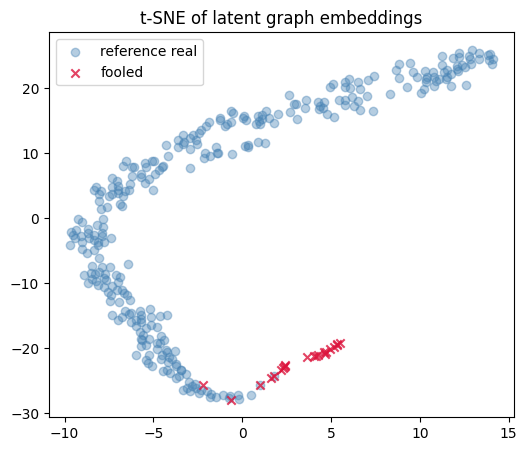

In [22]:
with torch.no_grad():
    z_nodes = [discriminator.encoder(g) for g in graphs]
    z_graph = torch.vstack([global_add_pool(z, g.batch) for z, g in zip(z_nodes, graphs)]).cpu().numpy()

    real_sample = random.sample(real_dataset, k=min(300, len(real_dataset)))
    z_ref = torch.vstack([global_add_pool(discriminator.encoder(d), d.batch).cpu() for d in real_sample])
    labels = np.concatenate([np.zeros(len(z_graph)), np.ones(len(z_ref))])
    X = np.vstack([z_graph, z_ref])

tsne = TSNE(perplexity=30, init="random").fit_transform(X)
plt.figure(figsize=(6,5))
plt.scatter(tsne[labels==1,0], tsne[labels==1,1],
            alpha=.4, label="reference real", c="steelblue")
plt.scatter(tsne[labels==0,0], tsne[labels==0,1],
            alpha=.8, label="fooled",     c="crimson", marker="x")
plt.legend(); plt.title("t-SNE of latent graph embeddings"); plt.show()



In [7]:
node_size = data_loader.get_node_size()

# Completely synthetic data
def simulate_matching_chunks(num_chunks: int):
    chunks = []
    for _ in range(num_chunks):
        bold_fake = torch.randn(node_size, 50, device=device)
        sc_fake   = torch.rand(node_size, node_size, device=device)
        sc_fake   = (sc_fake + sc_fake.T) / 2
        chunks.append(builder.build_graph(bold_fake, sc_fake, label=0))
    return chunks

fake_dataset = simulate_matching_chunks(len(real_dataset))

In [20]:
full_dataset = real_dataset + fake_dataset

in_dim = real_dataset[0].x.size(1)
hidden_dim = 64
latent_dim = 32

encoder = GraphEncoder(in_dim, hidden_dim, latent_dim)
train_contrastive(encoder, real_dataset, epochs=100, batch=64, device=device)

Contrastive pre-train:   0%|          | 0/100 [00:00<?, ?it/s]

Contrastive pre-train:   1%|          | 1/100 [00:00<01:17,  1.28it/s, loss=8.6736]

Epoch   0 loss 8.6736  align 1.000  uniform -0.003


Contrastive pre-train:  21%|██        | 21/100 [00:16<01:01,  1.29it/s, loss=0.7676]

Epoch  20 loss 0.7676  align 1.000  uniform -0.006


Contrastive pre-train:  41%|████      | 41/100 [00:31<00:46,  1.28it/s, loss=0.7418]

Epoch  40 loss 0.7418  align 1.000  uniform -0.005


Contrastive pre-train:  61%|██████    | 61/100 [00:47<00:30,  1.28it/s, loss=0.7283]

Epoch  60 loss 0.7283  align 1.000  uniform -0.007


Contrastive pre-train:  81%|████████  | 81/100 [01:03<00:14,  1.28it/s, loss=0.7235]

Epoch  80 loss 0.7235  align 1.000  uniform -0.007


Contrastive pre-train: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s, loss=0.7197]

Constrastive pre-training complete in 78.1s


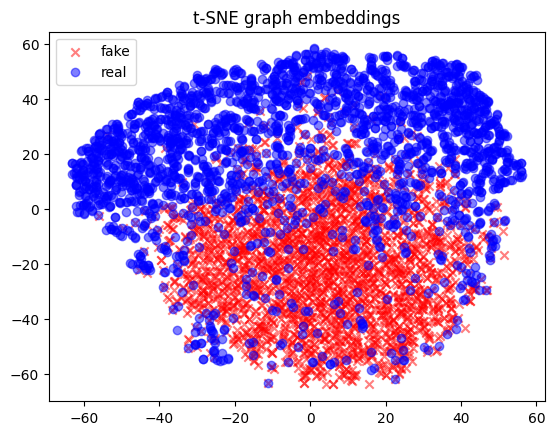

In [21]:

tsne_plot( np.vstack([global_add_pool(encoder(d.to(DEVICE)), d.batch).detach().cpu().numpy()
               for d in real_dataset+fake_dataset]), np.array([d.y.item() for d in real_dataset+fake_dataset]))


Binary Classifier: 100%|██████████| 60/60 [02:17<00:00,  2.30s/it, acc=100.00%, loss=0.0000]


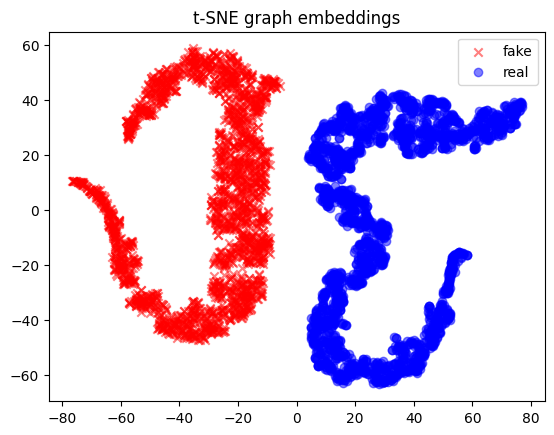

In [22]:
discriminator = Discriminator(encoder, latent=32, use_critic=False)

train_binary_classifier(discriminator, full_dataset, epochs=60, freeze_encoder=False, device=device)

tsne_plot( np.vstack([global_add_pool(encoder(d.to(DEVICE)), d.batch).detach().cpu().numpy()
               for d in real_dataset+fake_dataset]), np.array([d.y.item() for d in real_dataset+fake_dataset]))


In [25]:
# Save encoder
def save_frozen_models(encoder: nn.Module, discriminator: nn.Module, path_root = "checkpoints"):
    path_root = Path(path_root)
    path_root.mkdir(parents=True, exist_ok=True)
    torch.save(encoder.state_dict(), path_root / "encoder.pt")
    torch.save(discriminator.state_dict(), path_root / "discriminator.pt")
    print("Successfully saved encoder and discriminator!")

save_frozen_models(encoder, discriminator)

Successfully saved encoder and discriminator!


Using in_dim = 108, hidden_dim = 64, latent_dim = 32


VGAE pre-train:   0%|          | 0/200 [00:05<?, ?it/s, loss=0.4543]

Recon Loss: 0.4546, KL Loss: 10.2300
[Latent] z mean: 0.0929 | std: 0.8561
[Epoch Stats] Pred mean: 0.0955 | min: 0.0000 | max: 0.4187
[Epoch Stats] True mean: 0.0942 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9435 | Spearman Corr: 0.9796
[Epoch Stats] MSE (dense): 0.003610
[Epoch Stats] Diagonal Pred Mean: 0.0000


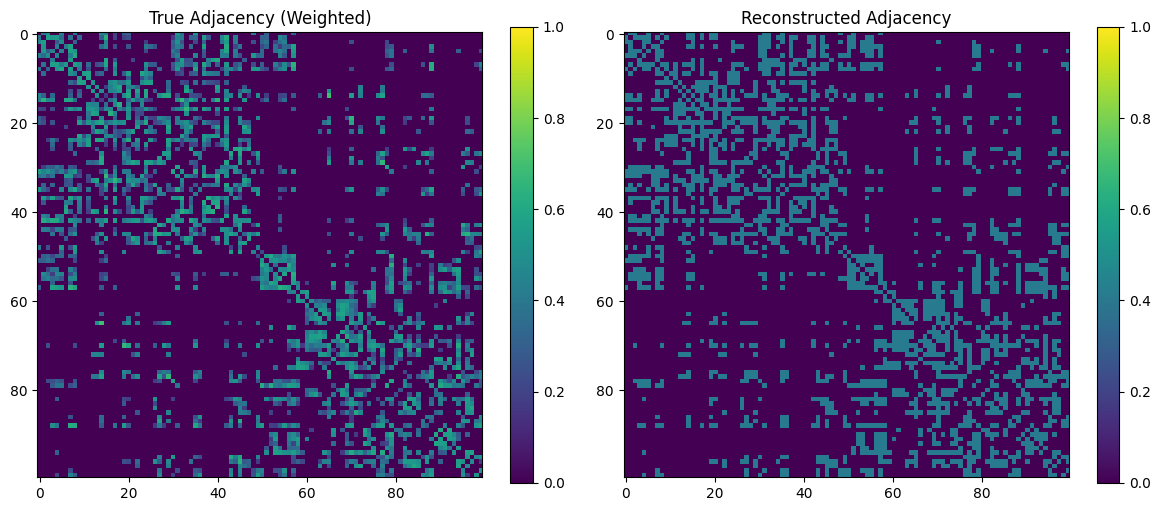

VGAE pre-train:  10%|█         | 20/200 [01:51<15:53,  5.29s/it, loss=0.4540]

Recon Loss: 0.4564, KL Loss: 0.0001
[Latent] z mean: 0.0072 | std: 1.0009
[Epoch Stats] Pred mean: 0.0915 | min: 0.0000 | max: 0.3980
[Epoch Stats] True mean: 0.0914 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9464 | Spearman Corr: 0.9792
[Epoch Stats] MSE (dense): 0.003258
[Epoch Stats] Diagonal Pred Mean: 0.0000


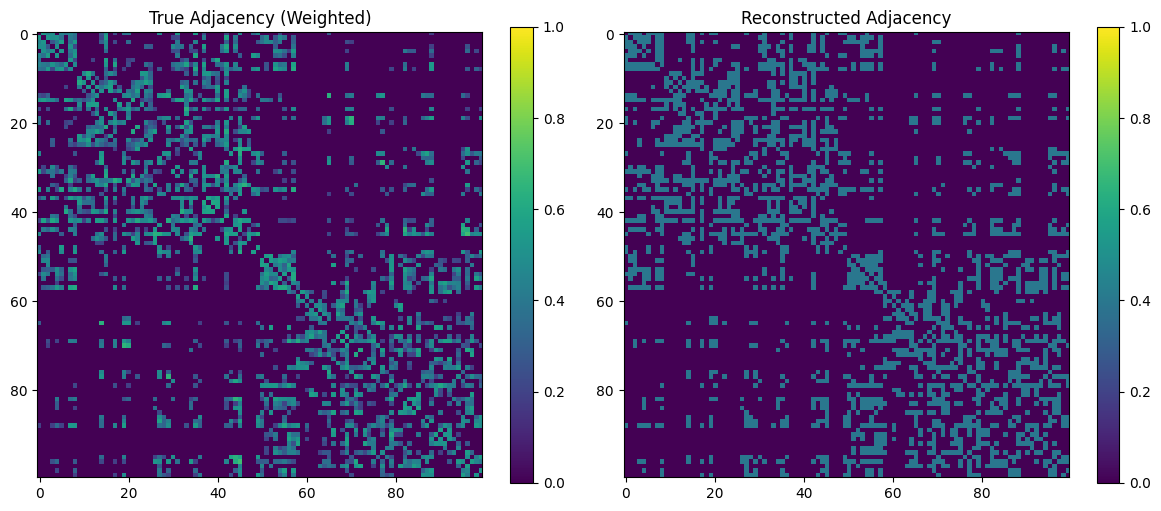

VGAE pre-train:  20%|██        | 40/200 [03:37<14:07,  5.30s/it, loss=0.4540]

Recon Loss: 0.4544, KL Loss: 0.0000
[Latent] z mean: -0.0067 | std: 0.9934
[Epoch Stats] Pred mean: 0.0980 | min: 0.0000 | max: 0.3962
[Epoch Stats] True mean: 0.0979 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9456 | Spearman Corr: 0.9863
[Epoch Stats] MSE (dense): 0.003449
[Epoch Stats] Diagonal Pred Mean: 0.0000


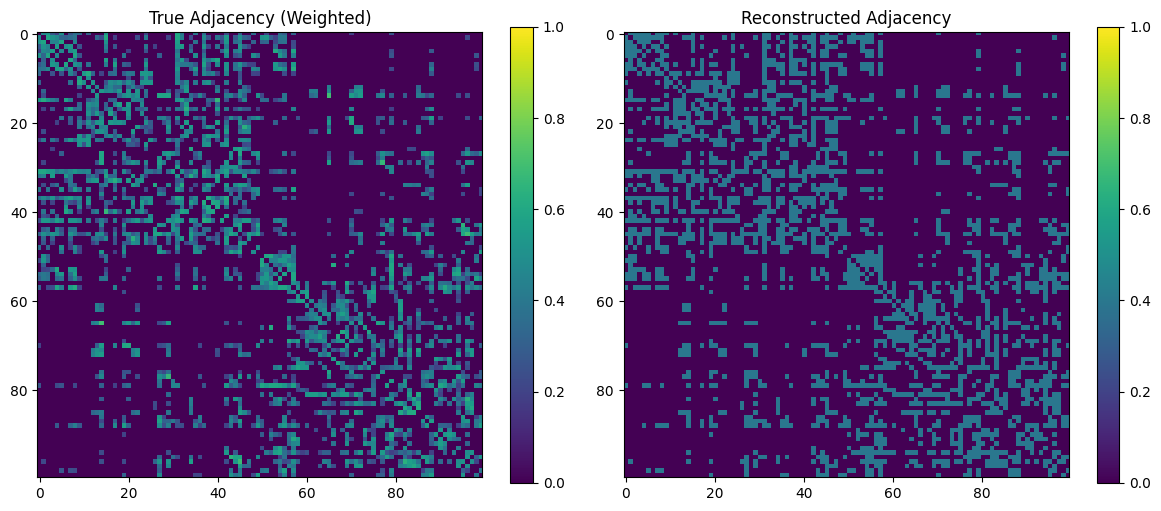

VGAE pre-train:  30%|███       | 60/200 [05:23<12:28,  5.35s/it, loss=0.4540]

Recon Loss: 0.4534, KL Loss: 0.0000
[Latent] z mean: -0.0075 | std: 0.9801
[Epoch Stats] Pred mean: 0.0916 | min: 0.0000 | max: 0.3982
[Epoch Stats] True mean: 0.0915 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9495 | Spearman Corr: 0.9879
[Epoch Stats] MSE (dense): 0.003059
[Epoch Stats] Diagonal Pred Mean: 0.0000


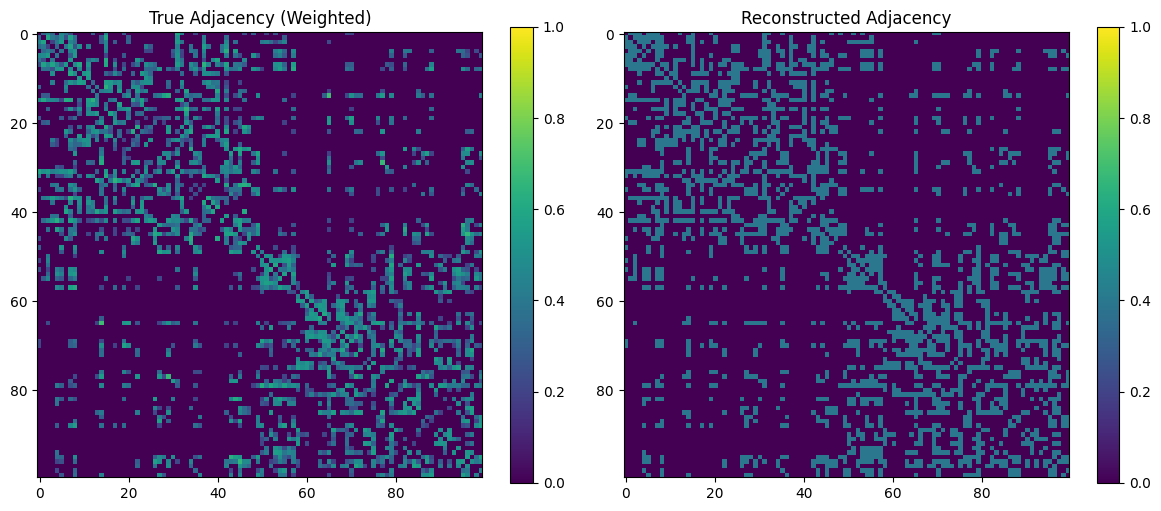

VGAE pre-train:  40%|████      | 80/200 [07:11<10:47,  5.40s/it, loss=0.4540]

Recon Loss: 0.4532, KL Loss: 0.0000
[Latent] z mean: -0.0205 | std: 0.9829
[Epoch Stats] Pred mean: 0.0866 | min: 0.0000 | max: 0.3938
[Epoch Stats] True mean: 0.0865 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9625 | Spearman Corr: 0.9898
[Epoch Stats] MSE (dense): 0.002108
[Epoch Stats] Diagonal Pred Mean: 0.0000


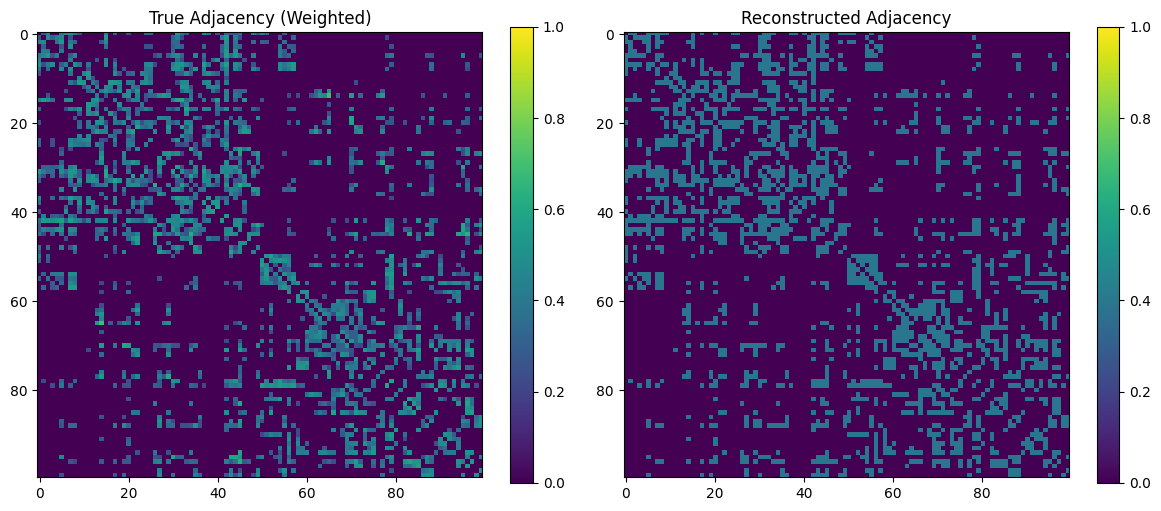

VGAE pre-train:  50%|█████     | 100/200 [08:57<08:50,  5.31s/it, loss=0.4540]

Recon Loss: 0.4526, KL Loss: 0.0000
[Latent] z mean: 0.0033 | std: 0.9879
[Epoch Stats] Pred mean: 0.0891 | min: 0.0000 | max: 0.4003
[Epoch Stats] True mean: 0.0890 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9519 | Spearman Corr: 0.9895
[Epoch Stats] MSE (dense): 0.002863
[Epoch Stats] Diagonal Pred Mean: 0.0000


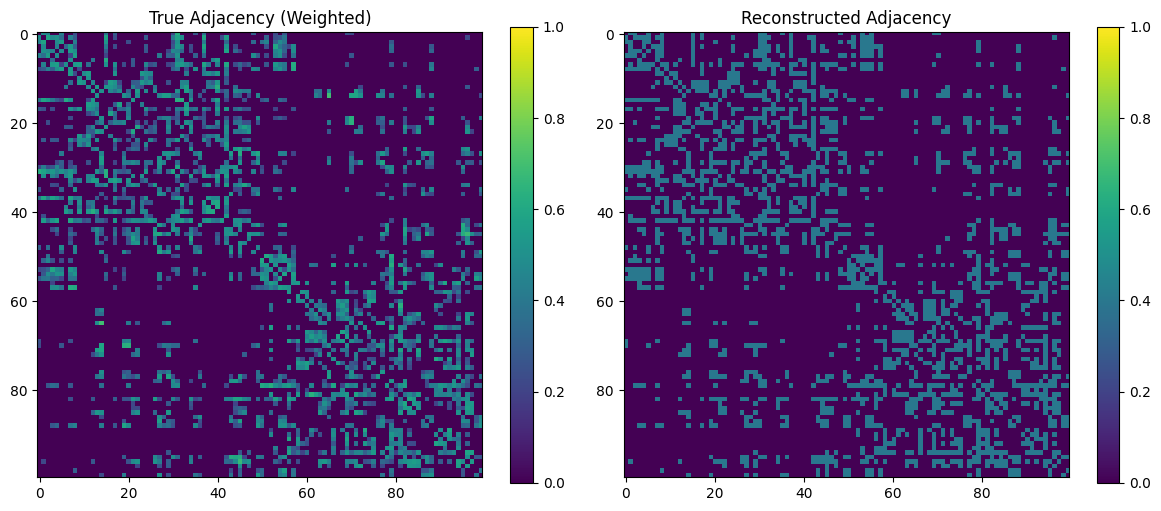

VGAE pre-train:  60%|██████    | 120/200 [10:43<07:00,  5.26s/it, loss=0.4540]

Recon Loss: 0.4553, KL Loss: 0.0000
[Latent] z mean: 0.0029 | std: 0.9957
[Epoch Stats] Pred mean: 0.0995 | min: 0.0000 | max: 0.3936
[Epoch Stats] True mean: 0.0993 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9294 | Spearman Corr: 0.9861
[Epoch Stats] MSE (dense): 0.004600
[Epoch Stats] Diagonal Pred Mean: 0.0000


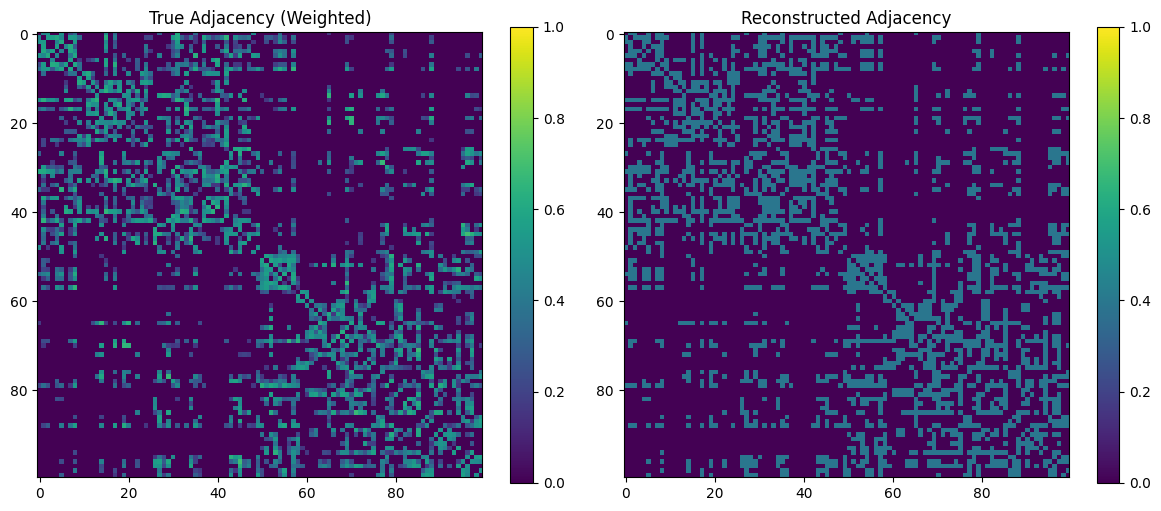

VGAE pre-train:  70%|███████   | 140/200 [12:29<05:18,  5.30s/it, loss=0.4540]

Recon Loss: 0.4535, KL Loss: 0.0000
[Latent] z mean: -0.0123 | std: 1.0040
[Epoch Stats] Pred mean: 0.1034 | min: 0.0000 | max: 0.3988
[Epoch Stats] True mean: 0.1032 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9449 | Spearman Corr: 0.9852
[Epoch Stats] MSE (dense): 0.003654
[Epoch Stats] Diagonal Pred Mean: 0.0000


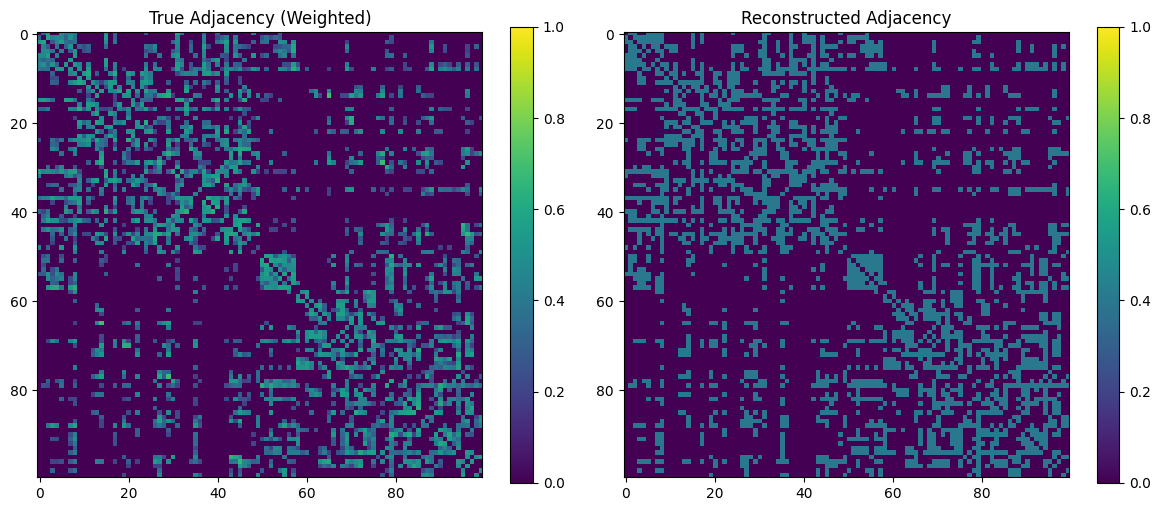

VGAE pre-train:  80%|████████  | 160/200 [14:15<03:31,  5.29s/it, loss=0.4540]

Recon Loss: 0.4543, KL Loss: 0.0000
[Latent] z mean: 0.0127 | std: 0.9922
[Epoch Stats] Pred mean: 0.0832 | min: 0.0000 | max: 0.3880
[Epoch Stats] True mean: 0.0830 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9585 | Spearman Corr: 0.9904
[Epoch Stats] MSE (dense): 0.002237
[Epoch Stats] Diagonal Pred Mean: 0.0000


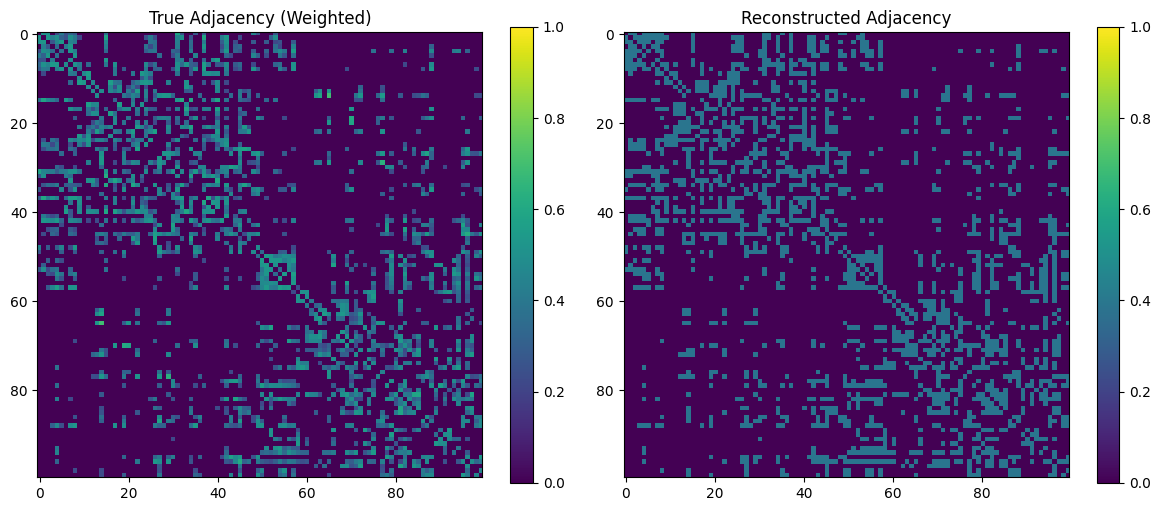

VGAE pre-train:  90%|█████████ | 180/200 [16:02<01:47,  5.39s/it, loss=0.4540]

Recon Loss: 0.4546, KL Loss: 0.0000
[Latent] z mean: 0.0154 | std: 0.9979
[Epoch Stats] Pred mean: 0.0888 | min: 0.0000 | max: 0.3960
[Epoch Stats] True mean: 0.0886 | min: 0.0000 | max: 0.6931
[Epoch Stats] Pearson Corr: 0.9573 | Spearman Corr: 0.9894
[Epoch Stats] MSE (dense): 0.002476
[Epoch Stats] Diagonal Pred Mean: 0.0000


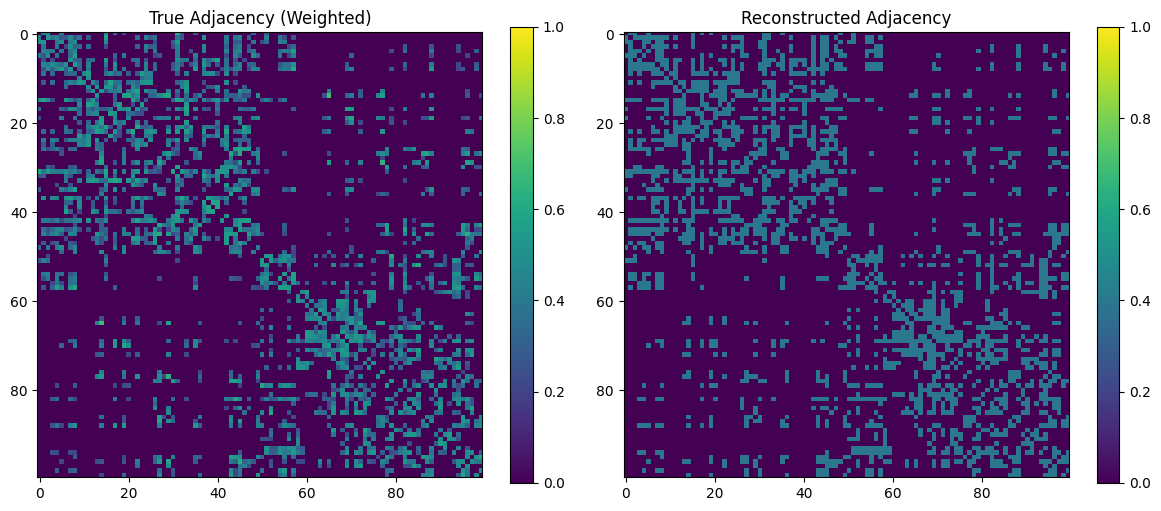

VGAE pre-train: 100%|██████████| 200/200 [17:43<00:00,  5.32s/it, loss=0.4540]


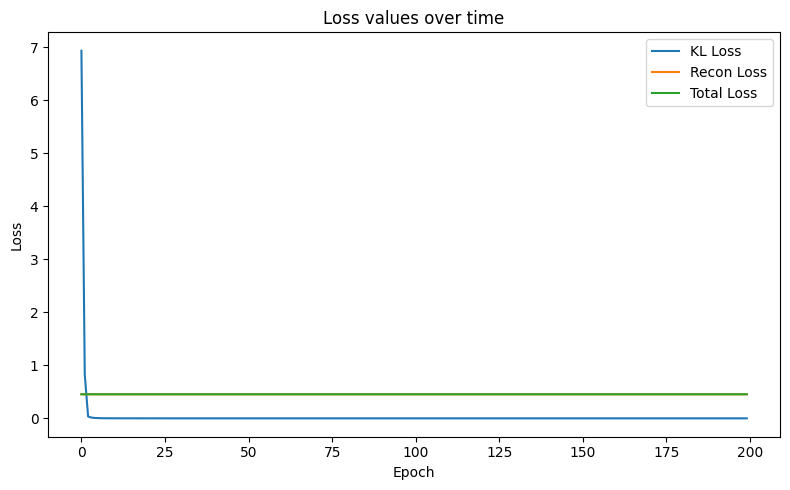

[VGAE] Frozen training


In [121]:
# MARK: Archived code - Saved for reconstruction plots

# in_dim = real_dataset[0].x.size(1)
# hidden_dim = 64
# latent_dim = 32

# print(f"Using in_dim = {in_dim}, hidden_dim = {hidden_dim}, latent_dim = {latent_dim}")
# vgae = build_vgae(in_dim=in_dim, hidden=64, latent=latent_dim)

# # 1. Unsupervised pre-train
# DiscriminatorVGAE.train_unsupervised(vgae, real_dataset, beta=0.1, device="cuda", warmup_epochs=100)
